In [1]:
library(ggplot2)
library(SingleR)
library(dplyr)
library(celldex)
library(RColorBrewer)

source("../tools/formating/formating.R")

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
# inupt_path <- "/ps/ai-ready/data/filtered_gene_bc_matrices/hg19/"
inupt_path <- "/ps/ai-ready/data/kbcfh/Anndata/hca_heart_neuronal_raw.h5ad"
path_of_scrublet_calls<-"/ps/ai-ready/data/filtered_gene_bc_matrices/hg19/scrublet_calls.tsv"

In [3]:
srat <- load_seurat(inupt_path)
srat

[1] "Inside load_seurat 1"


Warning message:
“Unknown file type: h5ad”
Creating h5Seurat file for version 3.1.5.9900

Adding X as data

Adding X as counts

Adding meta.features from var

Adding X_pca as cell embeddings for pca

Adding X_umap as cell embeddings for umap

Adding cell_type_colors to miscellaneous data

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction pca

Adding cell embeddings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



An object of class Seurat 
33538 features across 3961 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

In [4]:
default_assay <- "RNA"

In [5]:
if(!default_assay %in% names(x = srat)) stop(paste(default_assay, "does not exist."))
DefaultAssay(object = srat) <-default_assay

In [6]:
head(srat[[]])

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,source,type,version,cell_states,Used
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
AACCCAAAGTACGAGC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,5796,3033,0.0041407868,0.001897861,AX,H0015_apex,0.13934426,Nuclei,DBD,V3,NC3,Yes
AACCTGATCAGCTTCC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,3295,1696,0.0006069803,0.001517451,AX,H0015_apex,0.02730375,Nuclei,DBD,V3,NC4,Yes
AACGAAACACGACTAT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,743,567,0.0080753705,0.001345895,AX,H0015_apex,0.01520637,Nuclei,DBD,V3,NC1,Yes
AAGTGAATCGAGAGCA-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,562,441,0.0053380784,0.005338078,AX,H0015_apex,0.01428571,Nuclei,DBD,V3,NC1,Yes
AAGTGAATCTGATTCT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,984,723,0.0040650405,0.000000000,AX,H0015_apex,0.01520637,Nuclei,DBD,V3,NC1,Yes
AATTCCTCACATTACG-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,583,428,0.0017152659,0.005145798,AX,H0015_apex,0.05771496,Nuclei,DBD,V3,NC1,Yes


In [7]:
srat[[default_assay]]@counts

  [[ suppressing 32 column names ‘AACCCAAAGTACGAGC-1-H0015_apex’, ‘AACCTGATCAGCTTCC-1-H0015_apex’, ‘AACGAAACACGACTAT-1-H0015_apex’ ... ]]

  [[ suppressing 32 column names ‘AACCCAAAGTACGAGC-1-H0015_apex’, ‘AACCTGATCAGCTTCC-1-H0015_apex’, ‘AACGAAACACGACTAT-1-H0015_apex’ ... ]]

  [[ suppressing 32 column names ‘AACCCAAAGTACGAGC-1-H0015_apex’, ‘AACCTGATCAGCTTCC-1-H0015_apex’, ‘AACGAAACACGACTAT-1-H0015_apex’ ... ]]



33538 x 3961 sparse Matrix of class "dgCMatrix"
                                                                                     
MIR1302-2HG   . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
FAM138A       . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
OR4F5         . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AL627309.1    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AL627309.3    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AL627309.2    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AL627309.4    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AL732372.1    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
OR4F29        . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
AC114498.1    . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . ......
OR4F16

In [8]:
if(!paste0("nCount_", default_assay) %in% names(x = srat[[]])) srat[[paste0("nCount_", default_assay)]] <- colSums(x = srat[[default_assay]], slot = "counts")  # nCount of the default assay
if(!paste0("nFeature_", default_assay) %in% names(x = srat[[]])) srat[[paste0("nFeature_", default_assay)]] <- colSums(x = GetAssayData(object = srat[[default_assay]], slot = "counts") > 0)  # nFeature of the default assay

In [9]:
meta <- srat@meta.data
dim(meta)
head(meta)

summary(meta[paste0("nCount_", default_assay)])
summary(meta[paste0("nFeature_", default_assay)])

[1] 3961   20

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,source,type,version,cell_states,Used,nCount_RNA,nFeature_RNA
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>
AACCCAAAGTACGAGC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,5796,3033,0.0041407868,0.001897861,AX,H0015_apex,0.13934426,Nuclei,DBD,V3,NC3,Yes,5796,3033
AACCTGATCAGCTTCC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,3295,1696,0.0006069803,0.001517451,AX,H0015_apex,0.02730375,Nuclei,DBD,V3,NC4,Yes,3295,1696
AACGAAACACGACTAT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,743,567,0.0080753705,0.001345895,AX,H0015_apex,0.01520637,Nuclei,DBD,V3,NC1,Yes,743,567
AAGTGAATCGAGAGCA-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,562,441,0.0053380784,0.005338078,AX,H0015_apex,0.01428571,Nuclei,DBD,V3,NC1,Yes,562,441
AAGTGAATCTGATTCT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,984,723,0.0040650405,0.000000000,AX,H0015_apex,0.01520637,Nuclei,DBD,V3,NC1,Yes,984,723
AATTCCTCACATTACG-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,583,428,0.0017152659,0.005145798,AX,H0015_apex,0.05771496,Nuclei,DBD,V3,NC1,Yes,583,428


   nCount_RNA   
 Min.   :  501  
 1st Qu.:  717  
 Median : 1039  
 Mean   : 1620  
 3rd Qu.: 1858  
 Max.   :14582  

  nFeature_RNA   
 Min.   : 315.0  
 1st Qu.: 516.0  
 Median : 716.0  
 Mean   : 952.1  
 3rd Qu.:1151.0  
 Max.   :4326.0  

In [10]:
srat[["percent.mt"]] <- PercentageFeatureSet(srat, pattern = "^MT-") # Michochondrial genes
srat[["percent.rb"]] <- PercentageFeatureSet(srat, pattern = "^RP[SL]") # Ribosomal proteins (their names begin with RPS or RPL

In [11]:
# add the doublet annotation
doublets <- read.table(path_of_scrublet_calls, header = F, row.names = 1)
colnames(doublets) <- c("Doublet_score", "Is_doublet")
srat <- AddMetaData(srat, doublets)
head(srat[[]])

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,⋯,type,version,cell_states,Used,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,Doublet_score,Is_doublet
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
AACCCAAAGTACGAGC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,5796,3033,0.0041407868,0.001897861,⋯,DBD,V3,NC3,Yes,5796,3033,0.41407867,0.2760524,NA,NA
AACCTGATCAGCTTCC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,3295,1696,0.0006069803,0.001517451,⋯,DBD,V3,NC4,Yes,3295,1696,0.06069803,0.2427921,NA,NA
AACGAAACACGACTAT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,743,567,0.0080753705,0.001345895,⋯,DBD,V3,NC1,Yes,743,567,0.80753701,0.4037685,NA,NA
AAGTGAATCGAGAGCA-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,562,441,0.0053380784,0.005338078,⋯,DBD,V3,NC1,Yes,562,441,0.53380783,0.8896797,NA,NA
AAGTGAATCTGATTCT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,984,723,0.0040650405,0.000000000,⋯,DBD,V3,NC1,Yes,984,723,0.40650407,0.1016260,NA,NA
AATTCCTCACATTACG-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,583,428,0.0017152659,0.005145798,⋯,DBD,V3,NC1,Yes,583,428,0.17152659,0.8576329,NA,NA


In [17]:
names(srat[[]])

[1] "NRP"            "age_group"      "cell_source"    "cell_type"     
 [5] "donor"          "gender"         "n_counts"       "n_genes"       
 [9] "percent_mito"   "percent_ribo"   "region"         "sample"        
[13] "scrublet_score" "source"         "type"           "version"       
[17] "cell_states"    "Used"           "nCount_RNA"     "nFeature_RNA"  
[21] "percent.mt"     "percent.rb"     "Doublet_score"  "Is_doublet"    
[25] "QC"

In [22]:
srat[[]]["scrublet_score"]

,scrublet_score
,<dbl>
AACCCAAAGTACGAGC-1-H0015_apex,0.13934426
AACCTGATCAGCTTCC-1-H0015_apex,0.02730375
AACGAAACACGACTAT-1-H0015_apex,0.01520637
AAGTGAATCGAGAGCA-1-H0015_apex,0.01428571
AAGTGAATCTGATTCT-1-H0015_apex,0.01520637
AATTCCTCACATTACG-1-H0015_apex,0.05771496
AATTCCTCACGTCGTG-1-H0015_apex,0.09375000
ACGGAAGTCGACCAAT-1-H0015_apex,0.03284672
ACTTAGGTCCCTCTCC-1-H0015_apex,0.03284672


In [16]:
doublets

,Doublet_score,Is_doublet
,<dbl>,<chr>
AAACATACAACCAC-1,0.07095662,False
AAACATTGAGCTAC-1,0.07469772,False
AAACATTGATCAGC-1,0.08755760,False
AAACCGTGCTTCCG-1,0.05270776,False
AAACCGTGTATGCG-1,0.06744623,False
AAACGCACTGGTAC-1,0.05270776,False
AAACGCTGACCAGT-1,0.06744623,False
AAACGCTGGTTCTT-1,0.05270776,False
AAACGCTGTAGCCA-1,0.09781644,False


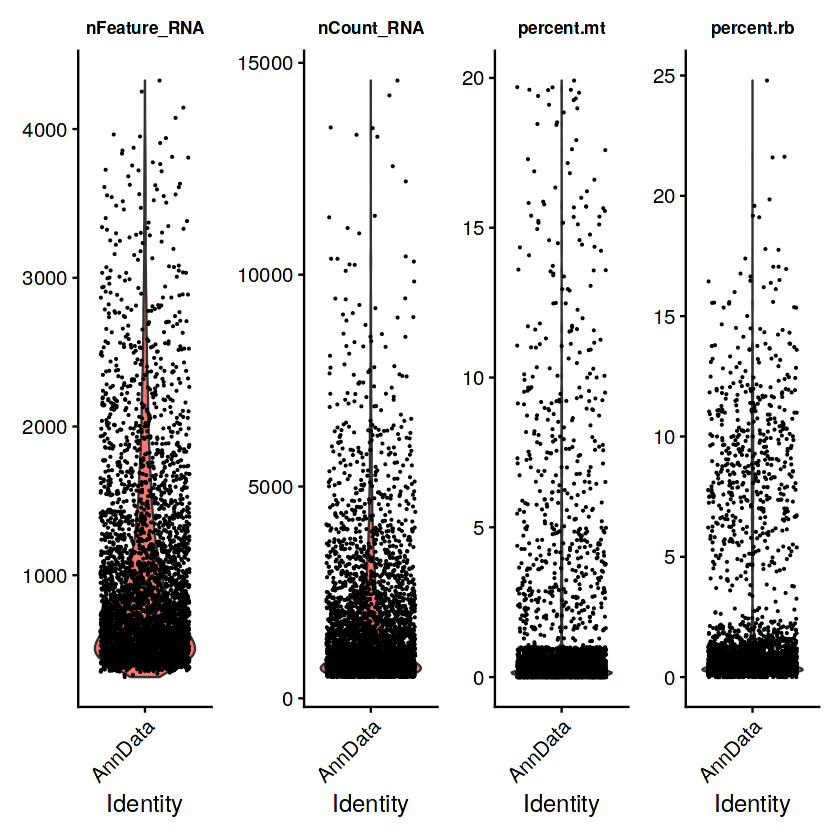

In [12]:
VlnPlot(srat, features = c(paste0("nFeature_", default_assay), paste0("nCount_", default_assay),"percent.mt","percent.rb"),ncol = 4,pt.size = 0.1) & 
  theme(plot.title = element_text(size=10))

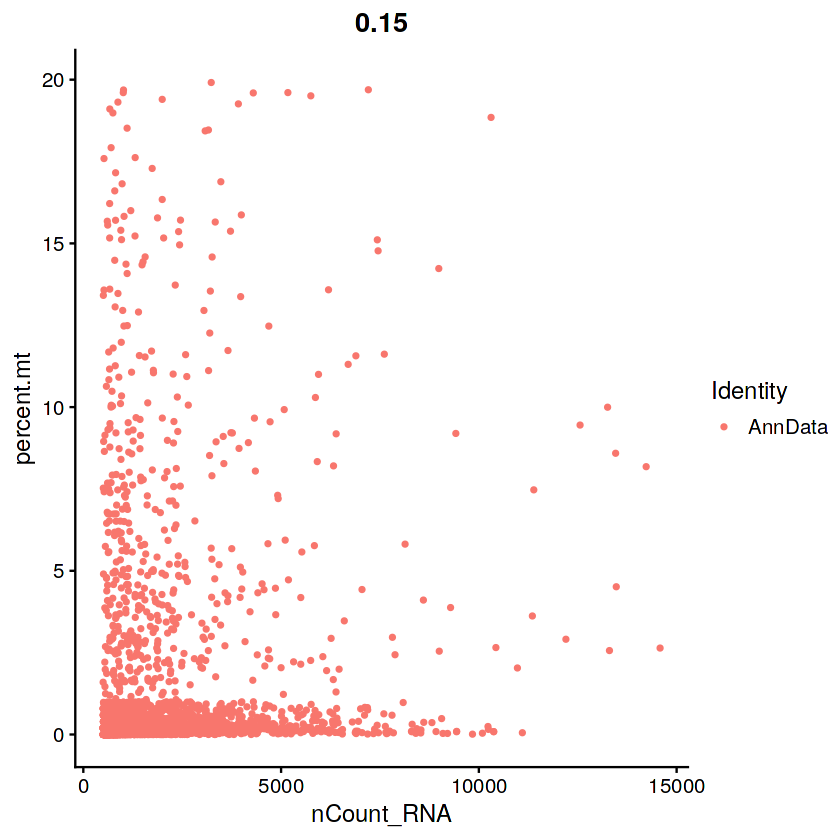

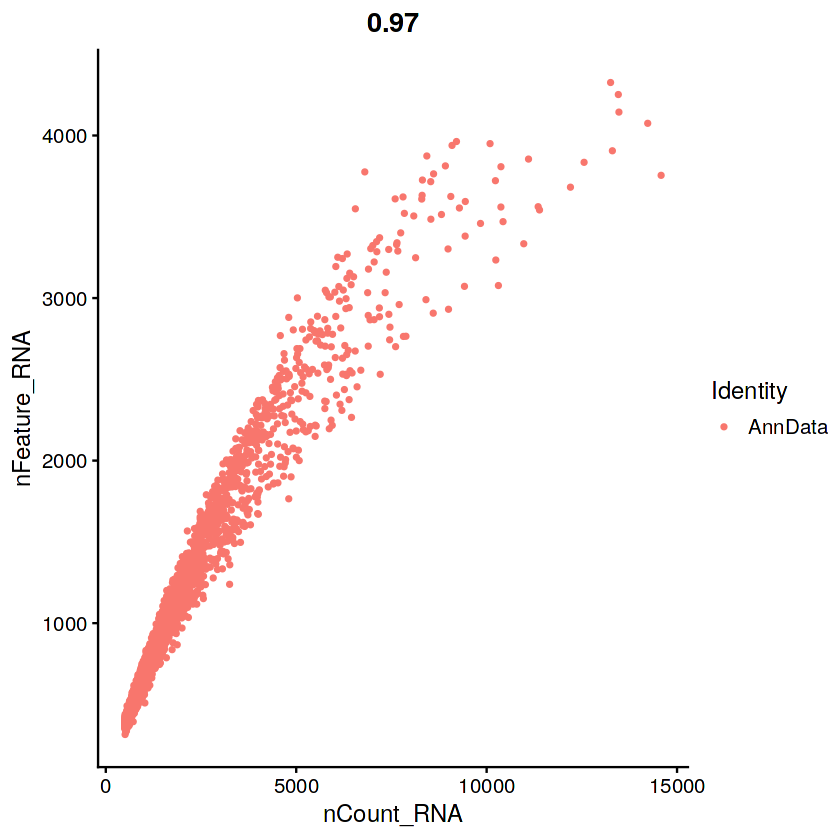

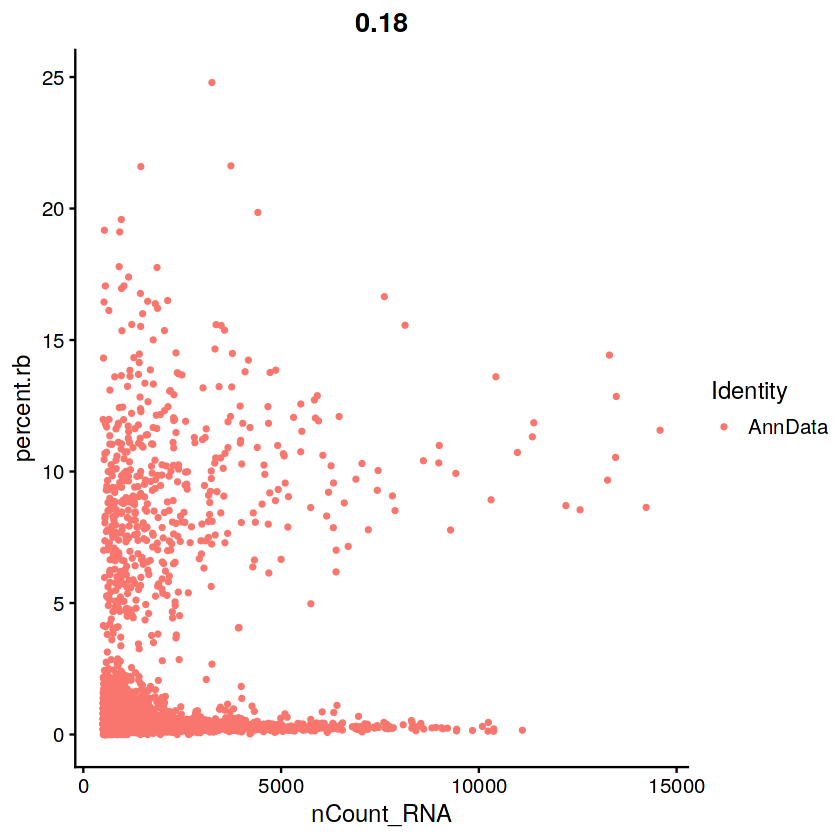

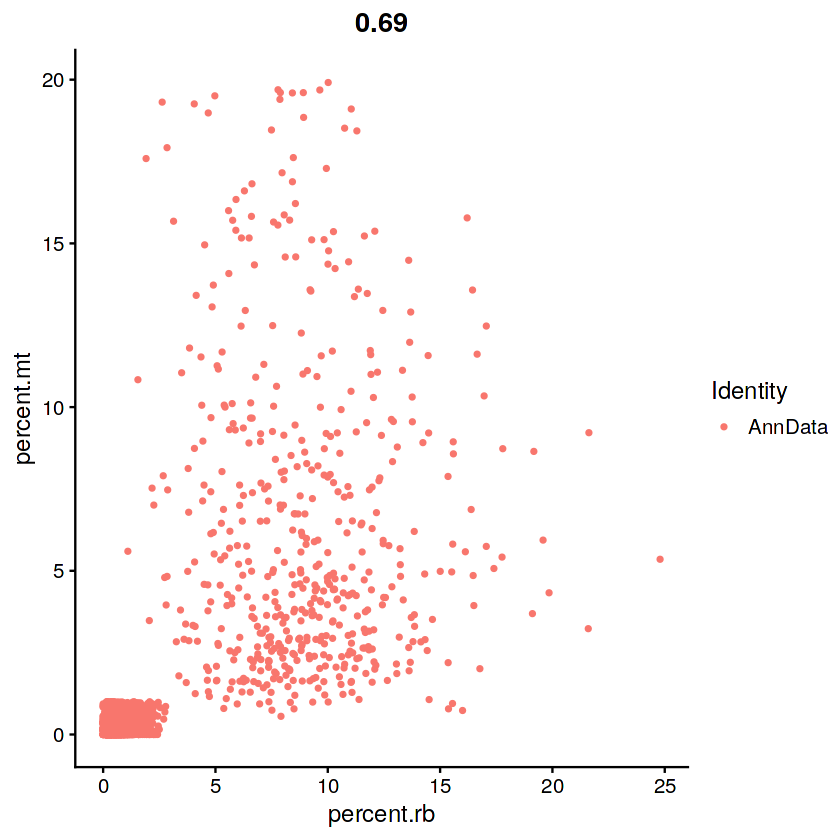

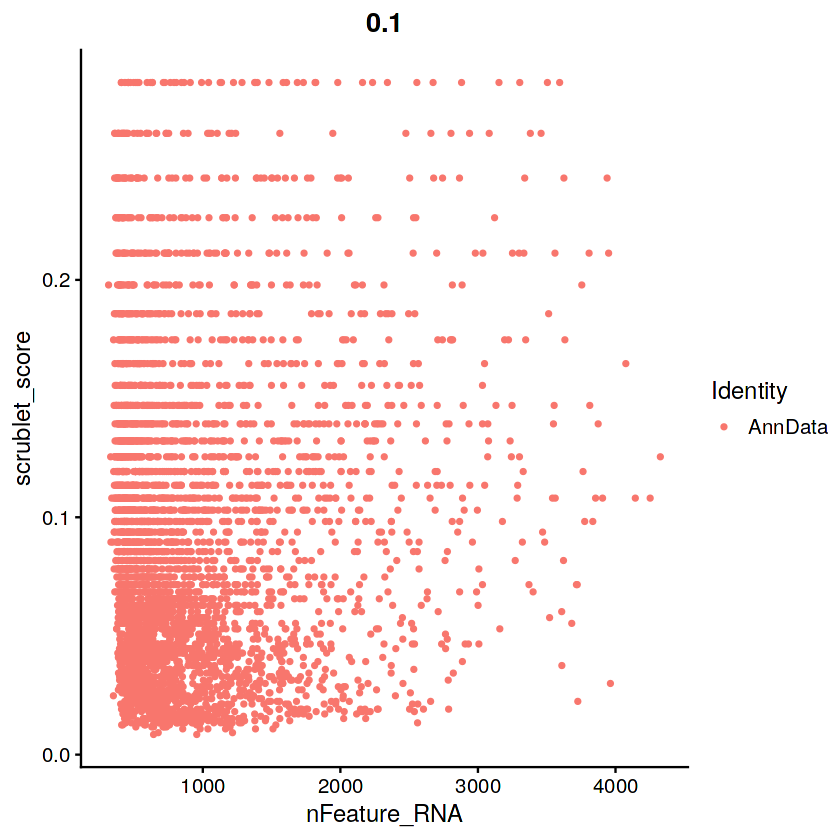

In [23]:
FeatureScatter(srat, feature1 = paste0("nCount_", default_assay), feature2 = "percent.mt")
FeatureScatter(srat, feature1 = paste0("nCount_", default_assay), feature2 = paste0("nFeature_", default_assay))
FeatureScatter(srat, feature1 = paste0("nCount_", default_assay), feature2 = "percent.rb")
FeatureScatter(srat, feature1 = "percent.rb", feature2 = "percent.mt")
# FeatureScatter(srat, feature1 = paste0("nFeature_", default_assay), feature2 = "Doublet_score")
FeatureScatter(srat, feature1 = paste0("nFeature_", default_assay), feature2 = "scrublet_score")

In [14]:
srat[['QC']] <- ifelse(srat@meta.data$Is_doublet == 'True','Doublet','Pass')
srat[['QC']] <- ifelse(srat@meta.data[paste0("nFeature_", default_assay)] < 500 & srat@meta.data$QC == 'Pass','Low_nFeature',srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data[paste0("nFeature_", default_assay)] < 500 & srat@meta.data$QC != 'Pass' & srat@meta.data$QC != 'Low_nFeature',paste('Low_nFeature',srat@meta.data$QC,sep = ','),srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data$percent.mt > 15 & srat@meta.data$QC == 'Pass','High_MT',srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data[paste0("nFeature_", default_assay)] < 500 & srat@meta.data$QC != 'Pass' & srat@meta.data$QC != 'High_MT',paste('High_MT',srat@meta.data$QC,sep = ','),srat@meta.data$QC)
table(srat[['QC']])

< table of extent 0 >

In [15]:
srat[[]]

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,⋯,version,cell_states,Used,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,Doublet_score,Is_doublet,QC
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,"<lgl[,1]>"
AACCCAAAGTACGAGC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,5796,3033,0.0041407868,0.0018978606,⋯,V3,NC3,Yes,5796,3033,0.41407867,0.2760524,NA,NA,NA
AACCTGATCAGCTTCC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,3295,1696,0.0006069803,0.0015174507,⋯,V3,NC4,Yes,3295,1696,0.06069803,0.2427921,NA,NA,NA
AACGAAACACGACTAT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,743,567,0.0080753705,0.0013458950,⋯,V3,NC1,Yes,743,567,0.80753701,0.4037685,NA,NA,NA
AAGTGAATCGAGAGCA-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,562,441,0.0053380784,0.0053380784,⋯,V3,NC1,Yes,562,441,0.53380783,0.8896797,NA,NA,NA
AAGTGAATCTGATTCT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,984,723,0.0040650405,0.0000000000,⋯,V3,NC1,Yes,984,723,0.40650407,0.1016260,NA,NA,NA
AATTCCTCACATTACG-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,583,428,0.0017152659,0.0051457975,⋯,V3,NC1,Yes,583,428,0.17152659,0.8576329,NA,NA,NA
AATTCCTCACGTCGTG-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,603,450,0.0000000000,0.0016583748,⋯,V3,NC1,Yes,603,450,0.00000000,0.4975124,NA,NA,NA
ACGGAAGTCGACCAAT-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,906,653,0.0088300221,0.0000000000,⋯,V3,NC1,Yes,906,653,0.88300221,0.1103753,NA,NA,NA
ACTTAGGTCCCTCTCC-1-H0015_apex,No,50-55,Harvard-Nuclei,Neuronal,H5,Female,699,543,0.0028612304,0.0028612304,⋯,V3,NC1,Yes,699,543,0.28612303,0.5722461,NA,NA,NA


In [ ]:
VlnPlot(srat, features = c("nFeature_RNA","nCount_RNA","percent.mt","percent.rb"),ncol = 4,pt.size = 0.1) & 
  theme(plot.title = element_text(size=10))

In [ ]:
FeatureScatter(srat, feature1 = "nCount_RNA", feature2 = "percent.mt")
FeatureScatter(srat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
FeatureScatter(srat, feature1 = "nCount_RNA", feature2 = "percent.rb")
FeatureScatter(srat, feature1 = "percent.rb", feature2 = "percent.mt")
FeatureScatter(srat, feature1 = "nFeature_RNA", feature2 = "Doublet_score")

In [ ]:
srat[['QC']] <- ifelse(srat@meta.data$Is_doublet == 'True','Doublet','Pass')
srat[['QC']] <- ifelse(srat@meta.data$nFeature_RNA < 500 & srat@meta.data$QC == 'Pass','Low_nFeature',srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data$nFeature_RNA < 500 & srat@meta.data$QC != 'Pass' & srat@meta.data$QC != 'Low_nFeature',paste('Low_nFeature',srat@meta.data$QC,sep = ','),srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data$percent.mt > 15 & srat@meta.data$QC == 'Pass','High_MT',srat@meta.data$QC)
srat[['QC']] <- ifelse(srat@meta.data$nFeature_RNA < 500 & srat@meta.data$QC != 'Pass' & srat@meta.data$QC != 'High_MT',paste('High_MT',srat@meta.data$QC,sep = ','),srat@meta.data$QC)
table(srat[['QC']])

In [ ]:
srat[['QC']]

In [ ]:
VlnPlot(subset(srat, subset = QC == 'Pass'), 
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.rb"), ncol = 4, pt.size = 0.1) & 
  theme(plot.title = element_text(size=10))